In [1]:
from sunlab.globals import FILES

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# import tensorflow as tf
# tf.autograph.set_verbosity(0, False)
# from matplotlib import pyplot as plt

import joblib
try:
    import sklearn.externals.joblib as extjoblib
except:
    pass

In [3]:
def load_model(model_pkl_path, scaler_pkl_path):
    clf = joblib.load(model_pkl_path)
    scaler = joblib.load(scaler_pkl_path)
    return clf, scaler

In [4]:
def load_test_data(data, d=1, pixel2dist = 1.075268):
    from transform_data import Add_Measures, Exclude_Measures
    """
    Encapsulates SVM_csv.py

    Inputs:
        data_path: path to CSV data you wish to be evaluated
        write_txt: write text file with probabilities etc.
        d: dimensionality to which increase features. If d=2, quadratic, cross features are included.

    Outputs:
        Nothing, as of yet.
    """
#     data = dataset.dataframe[dataset.data_columns].to_numpy()
#     pixel2dist = 1.075268
    #pixel2dist=0.53763672 #microns/pixel using 20x oil objective lens on confocal
    #pixel2dist=0.656265 #using 20x oil lens, microns/pixel on dark room microscope
    #pixel2dist=1.075268 #using 10x air objective on the confocal

    print('Data is being converted to correct micrometers, assuming measured in pixels')
    #scale columns by following
    data[:,0] =data[:,0]*pixel2dist*pixel2dist#area
    data[:,1] = data[:,1]*pixel2dist#majoraxislength
    data[:,2] = data[:,2]*pixel2dist#minoraxislength
    #3 is eccentricity, unitless
    data[:,4] =data[:,4]*pixel2dist*pixel2dist#4 convex area,
    data[:,5] = data[:,5]*pixel2dist#5 Equiv diam
    #6 solidity, unitless
    #7 extent, unitless
    data[:,8] = data[:,8]*pixel2dist#8 Perimeter
    data[:,9] = data[:,9]*pixel2dist#9 Convex Perimeter
    data[:,10] = data[:,10]*pixel2dist#10 Fiber Length
    data[:,11] = data[:,11]*pixel2dist#11 Max Inscribed Radius
    data[:,12] = data[:,12]*pixel2dist#12 Bleb_length


    #add form factor as last column of data?
    #Form factor is added inside the Processing data when doing SVM. See "Transform_data.py"

    #if len(Measure_Delete)>0:
    #	data = np.delete(data, Measure_Delete, axis = 1) #delete time column and cellnumber column, since we already have them.

    #so now data should look just like other data used in SVM

    #add aspect ratio as last column of data
    X_data = Add_Measures(data, add_AR=True, add_FF=True, add_convexity=True,
                            add_curl_old=True, add_curl=True, add_sphericity=True,
                            add_InscribedArea=True, add_BlebRel=True)
    #if you wish to exclude certain measures:
    #Area,MjrAxis,MnrAxis,Ecc,ConA,EqD,Sol,Ext,Per,conPer,FL,InR,bleb_M
    X_data = Exclude_Measures(X_data, ex_Area=False,
                            ex_MjrAxis=False, ex_MnrAxis=False, ex_Ecc=False,
                            ex_ConA=False, ex_EqD=False, ex_Sol=False, ex_Ext=False,
                            ex_Per=False,ex_conPer=False,ex_FL=False,ex_InR=False,
                            ex_bleb=False)

    ####IF THE DATA WAS POLYNOMIAL BEFORE SCALED, DO THAT NOW!
    #frameinfo = getframeinfo(currentframe())
    #print("IF YOUR SCALER IS A POLYNOMIAL, YOU NEED TO EDIT THE POLYNOMIAL FEATURES, LINE %d CODE" % (frameinfo.lineno + 2))
    #d = 1
    if d==2:
        print("Expanding feature set to include quadratic, cross terms.")
        poly=preprocessing.PolynomialFeatures(degree = d, interaction_only = True)
        X_data_exp = poly.fit_transform(X_data)

        #FIRST, SCALE THE DATA USING THE SCALER
        X_data_scaled = scaler.transform(X_data_exp)
    else:
        X_data_scaled = scaler.transform(X_data)

    #GATHER PROBABILITIES
    Probs = clf.predict_proba(X_data_scaled)

    #Gather Predictions
    Predictions = clf.predict(X_data_scaled)

    Descriptors = ['frame', 'cellnumber','x-cent','y-cent','actinedge','filopodia','bleb','lamellipodia']
    return Probs

In [5]:
model_pkl_path = FILES["SVM"]["MODEL"]
scaler_pkl_path = FILES["SVM"]["SCALER"]
clf, scaler = load_model(model_pkl_path, scaler_pkl_path)

/home/physics/cunnichr/.micromamba/envs/svm/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/physics/cunnichr/.micromamba/envs/svm/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecatio

In [8]:
from sunlab.common.data import *
from numpy import savetxt

In [51]:
import numpy as np
p2d = 1.075268/4
fname = FILES["HISTOLOGIES"]["J1"]
data = import_dataset(fname, 40, scaler=None)
# Ignore dirty masks from brush effects in masking process
df = data.dataframe[data.dataframe['Area']>350]
ds = df[data.data_columns].to_numpy()
out_data = load_test_data(ds, pixel2dist=p2d)
columns = ["frame", "cellnumber", "x-cent", "y-cent", "actinedge", "filopodia", "bleb", "lamellipodia"]
out = np.hstack([df[['Frames','CellNum','CenterX','CenterY']].to_numpy(), out_data])
savetxt(fname[:-3] + "txt", out, comments="", header=" ".join(columns))

Data is being converted to correct micrometers, assuming measured in pixels


/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:72: RuntimeWarning: No classification labels found for the dataset
  RuntimeWarning)


In [52]:
import numpy as np
p2d = 1.075268/4
fname = FILES["HISTOLOGIES"]["H9"]
data = import_dataset(fname, 40, scaler=None)
df = data.dataframe
ds = df[data.data_columns].to_numpy()
out_data = load_test_data(ds, pixel2dist=p2d)
columns = ["frame", "cellnumber", "x-cent", "y-cent", "actinedge", "filopodia", "bleb", "lamellipodia"]
out = np.hstack([df[['Frames','CellNum','CenterX','CenterY']].to_numpy(), out_data])
savetxt(fname[:-3] + "txt", out, comments="", header=" ".join(columns))

/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:72: RuntimeWarning: No classification labels found for the dataset
  RuntimeWarning)


Data is being converted to correct micrometers, assuming measured in pixels


In [9]:
import numpy as np
p2d = 1.075268/4
fname = FILES["HISTOLOGIES"]["H4"]
data = import_dataset(fname, 40, scaler=None)
df = data.dataframe
ds = df[data.data_columns].to_numpy()
out_data = load_test_data(ds, pixel2dist=p2d)
columns = ["frame", "cellnumber", "x-cent", "y-cent", "actinedge", "filopodia", "bleb", "lamellipodia"]
out = np.hstack([df[['Frames','CellNum','CenterX','CenterY']].to_numpy(), out_data])
savetxt(fname[:-3] + "txt", out, comments="", header=" ".join(columns))

Data is being converted to correct micrometers, assuming measured in pixels


/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:72: RuntimeWarning: No classification labels found for the dataset
  RuntimeWarning)


In [53]:
import numpy as np
p2d = 1.075268/4
fname = FILES["HISTOLOGIES"]["image001"]
data = import_dataset(fname, 40, scaler=None)
df = data.dataframe
# Ignore bad mask
df = df[df['Perimeter'] < 8500]
ds = df[data.data_columns].to_numpy()
out_data = load_test_data(ds, pixel2dist=p2d)
columns = ["frame", "cellnumber", "x-cent", "y-cent", "actinedge", "filopodia", "bleb", "lamellipodia"]
out = np.hstack([df[['Frames','CellNum','CenterX','CenterY']].to_numpy(), out_data])
savetxt(fname[:-3] + "txt", out, comments="", header=" ".join(columns))

Data is being converted to correct micrometers, assuming measured in pixels


/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:72: RuntimeWarning: No classification labels found for the dataset
  RuntimeWarning)


In [6]:
SAVE_OUT = False

In [9]:
from numpy import loadtxt, savetxt
data = loadtxt(FILES["PHENOTYPE_GRID"]["IN"])
classes = load_test_data(data)
if SAVE_OUT:
    savetxt(FILES["PHENOTYPE_GRID"]["OUT"], classes)

Data is being converted to correct micrometers, assuming measured in pixels


In [19]:
from numpy import argmax
im_classes = argmax(classes, axis=-1)
im_classes.shape

(250000,)

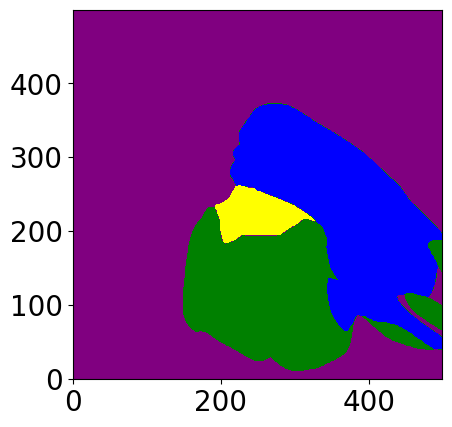

In [22]:
from matplotlib import pyplot as plt
from sunlab.common.plotting.colors import Pmap
plt.imshow(im_classes.reshape((500,500)).T, cmap=Pmap, origin='lower')

In [10]:
from json import dumps
print(dumps(FILES,indent=4))

{
    "TRAINING_DATASET": "../../data/spheroid26_011523_filtered.csv",
    "TRAINING_DATASET_WIDE_BERTH": "../../data/spheroid26_011523_exc.csv",
    "PRETRAINED_MODEL_DIR": "../../models/current_model/",
    "PEN_TRACKED": {
        "AUTO": "../../data/PEN_automatically_tracked.csv",
        "MANUAL": "../../data/PEN_manually_tracked.csv"
    },
    "RHO": {
        "3": "../../data/Rho_act_Cell3.csv",
        "4": "../../data/Rho_act_Cell4.csv",
        "6": "../../data/Rho_act_Cell6.csv",
        "7": "../../data/Rho_act_Cell7.csv",
        "8": "../../data/Rho_act_Cell8.csv",
        "9": "../../data/Rho_act_Cell9.csv",
        "10": "../../data/Rho_act_Cell10.csv",
        "11": "../../data/Rho_act_Cell11.csv"
    },
    "SPHEROID": {
        "1p5mgml": "../../data/spheroid26_011523_filtered.csv",
        "3mgml": "../../data/spheroid20_011923_filtered.csv",
        "4mgml": "../../data/spheroid22_012323_filtered.csv",
        "6mgml": "../../data/spheroid26_012423_filtered.csv"
 